In [1]:
# coding: utf-8
# наше всё
import numpy as np
import pandas as pd

#настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)


# будем отображать графики прямо в jupyter'e
import seaborn as sns
import matplotlib.pyplot as plt
# лучше не делать в линуксе
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

In [2]:
# словарь конвертирует исход в эло-результат
score_dct={
    'Win': 1,
    'Lose': 0,
    'Draw': 0.5,
    'Unknown': 0
        }


def get_season(lst):
    if len(lst)==5:
        return lst[3]
    else:
        return lst[2]
def get_division(txt):
    l=txt.split('.')
    return l[1]
def get_competition(txt):
    l=txt.split('.')
    return l[0]

def formatting(df):
    # дата в нормальном формате
    df['date']=df['date'].astype('datetime64[ns]')
    
    # если результат игры NULL, ставим -1
    df['home_result']=np.where(
        (df['gh']>df['ga']), 'Win', 
                                    np.where(
                                        (df['gh']<df['ga']), 'Lose', 'Draw'
                                            )
                                )
    df['away_result']=np.where(
        (df['gh']>df['ga']), 'Lose', 
                                    np.where(
                                        (df['gh']<df['ga']), 'Win', 'Draw'
                                            )
                                )
    
    df=df.rename(columns={
                        'full_time': 'result_kind',
                        'gh': 'home_score',
                        'ga': 'away_score',
                        'home': 'home_team',
                        'away': 'away_team'
                          })

    
    return df

def team_table(df):
    # делаем датасет, где каждая в фокусе команда, а не результат матча
    # сначала для хозяев, потом гостей
    df_home=df.copy()

    df_home['team'] = df_home['home_team']
    df_home['opponent'] = df_home['away_team']
    df_home['result'] = df_home['home_result']
    df_home['team_score'] = df_home['home_score']
    df_home['opponent_score'] = df_home['away_score']
    df_home['venue'] = 'Home'
    
    df_home['full_team_name'] = df_home['home_ident']
    df_home['opponent_full_team_name'] = df_home['away_ident']
    df_home['country'] = df_home['home_country']
    df_home['opponent_country'] = df_home['away_country']
    df_home['country_code'] = df_home['home_code']
    df_home['opponent_country_code'] = df_home['away_code']

    df_home=df_home[[
        'match_id', 'date', 'competition', 'level',
        'team', 'opponent', 'venue', 
        'result', 'result_kind',
        'team_score', 'opponent_score',
        'continent', 'country', 'opponent_country',
        'country_code', 'opponent_country_code',
        'full_team_name', 'opponent_full_team_name',
        'file'
                    ]]
    
    df_away=df.copy()
    
    df_away['team'] = df_away['away_team']
    df_away['opponent'] = df_away['home_team']
    df_away['result'] = df_away['away_result']
    df_away['team_score'] = df_away['away_score']
    df_away['opponent_score'] = df_away['home_score']
    df_away['venue'] = 'Away'

    df_away['full_team_name'] = df_away['away_ident']
    df_away['opponent_full_team_name'] = df_away['home_ident']
    df_away['country'] = df_away['away_country']
    df_away['opponent_country'] = df_away['home_country']
    df_away['country_code'] = df_away['away_code']
    df_away['opponent_country_code'] = df_away['home_code']
    
    df_away=df_away[[
    'match_id', 'date', 'competition', 'level',
    'team', 'opponent', 'venue', 
    'result', 'result_kind',
    'team_score', 'opponent_score',
    'continent', 'country', 'opponent_country',
    'country_code', 'opponent_country_code',
    'full_team_name', 'opponent_full_team_name',
    'file'
                ]]

    team_df=pd.concat([df_home, df_away]).sort_values(by='date')
    l=team_df.sort_values(['date'], ascending=[True]) \
                 .groupby(['team']) \
                 .cumcount() + 1
    team_df['game_number'] = l.values

    return team_df

# retunr classic Elo propabilities
# elo_prob(2882, 2722) -> 0.7152 (72% chanses Carlsen (2882) to beat Wan Hao (2722))
def elo_prob(rw, rb):
    try:
        rw=float(rw)
        rb=float(rb)
        res=1/(1+np.power(10, (rb-rw)/400))
    except:
        0.5
    return res

# изменение рейтинга по фактическому выступлению
def elo_rating_changes(rating, opponent_rating, score, games):
    # чтобы новички быстрее набирали рейтиг
    if games<=30:
        K=40
    else:
        # у топ-топов всё мееяется медленней
        if rating>2500:
            K=10
        elif rating<=2500:
            K=20
            
    expectation=elo_prob(rating, opponent_rating)
    new_rating=rating+K*(score-expectation)
    
    return new_rating

# на вход получаем список сущностей , 
# на выходе - стринга сочетаний сущеностей 
def get_all_sets(ll):
    rr=[]
    r=[]
    for i in ll:
        for j in ll:
            if i!=j:
                rr.append(str(i)+'-'+str(j))
    return rr


def count_elo_rating(team_df):
    # создаём словарь с текущими рейтингами, будем обновлять его после каждого матча
    teams=team_df['team'].value_counts().index
    
    # начальный рейтинг пусть будет 2400
    default_ratings=np.ones(len(teams))*2400
    current_rating_dict=dict(zip(teams, default_ratings))
    
    # добавдляем словарь статистики персональных встреч
    current_stat_dict=dict({'team1-team2': np.zeros(5)})

    # результаты для добавления в датафрейм
    ratings_lst=[]
    opponent_ratings_lst=[]
    ratings_chng_lst=[]
    wins_lst=[]
    draws_lst=[]
    loses_lst=[]
    scored_lst=[]
    mised_lst=[]
    
    # если сортировка будет не хронологической, то упс
    team_df=team_df.sort_values(by=['date', 'team'])
    
    # цикл по всем матчам
    for match in team_df.values:
        # если данных нет, не нужно менять рейтинг никак
#         пример строки 
#         699 Timestamp('2000-04-15 00:00:00') 'malaysia' 'national' 'Perlis'
#          'Selangor FC' 'Away' 'Draw' 'F' 2 2 'Asia' 'malaysia' 'malaysia' 'MY'
#          'MY' 'Perlis (Malaysia)' 'Selangor FC (Malaysia)'
#          'data/football-data/data/results/malaysia.csv' 1
        wins=0
        draws=0
        loses=0
        scored=0
        mised=0
        if match[7]!='Unknown':
            curr_t_str=str(match[4])+'-'+str(match[5])
            
            if (curr_t_str not in current_stat_dict.keys()):
                current_stat_dict.update({
                                        curr_t_str:np.zeros(5)
                                            })

            if match[7]=='Win':
                current_stat_dict[curr_t_str][0]=current_stat_dict[curr_t_str][0]+1
            elif match[7]=='Draw':
                current_stat_dict[curr_t_str][1]=current_stat_dict[curr_t_str][1]+1
                
            elif match[7]=='Lose':
                current_stat_dict[curr_t_str][2]=current_stat_dict[curr_t_str][2]+1
                
                
            wins=current_stat_dict[curr_t_str][0]
            wins_lst.append(wins) 
            draws=current_stat_dict[curr_t_str][1]
            draws_lst.append(draws)
            loses=current_stat_dict[curr_t_str][2]
            loses_lst.append(loses)
            
            
            current_stat_dict[curr_t_str][3]=current_stat_dict[curr_t_str][3]+match[9]
            scored=current_stat_dict[curr_t_str][3]
            scored_lst.append(scored)
            
            current_stat_dict[curr_t_str][4]=current_stat_dict[curr_t_str][4]+match[10]
            mised=current_stat_dict[curr_t_str][4]
            mised_lst.append(mised)
            
            # ожидаемый исход матча
            expectation=elo_prob(current_rating_dict[match[4]], 
                                 current_rating_dict[match[5]]
                                )
            # пересчёт нового рейтинга
            new_rating=elo_rating_changes(
                                    current_rating_dict[match[4]], 
                                    current_rating_dict[match[5]],
                                    score_dct[match[7]], match[19]
                                           )

            # изменение рейтинга    
            changing=new_rating-current_rating_dict[match[4]]

            # обновление рабочего словаря
            current_rating_dict.update({match[4]: new_rating})

            # а теперь пересчитаем рейтинг оппонента
            opponent_rating=current_rating_dict[match[5]]-changing
            
        else:
            new_rating=current_rating_dict[match[4]]
            changing=0
            opponent_rating=current_rating_dict[match[5]]
            
            wins=current_stat_dict[curr_t_str][0]
            draws=current_stat_dict[curr_t_str][1]
            loses=current_stat_dict[curr_t_str][2]
            scored=current_stat_dict[curr_t_str][3]
            mised=current_stat_dict[curr_t_str][4]
            
            wins_lst.append(wins)
            draws_lst.append(draws)
            loses_lst.append(loses)
            scored_lst.append(scored)
            mised_lst.append(mised)


        # списки рейтингов для передачи в датафрейм
        ratings_lst.append(new_rating)
        opponent_ratings_lst.append(opponent_rating)
        ratings_chng_lst.append(changing)
        
    # рейтинги ПО итогу матча
    team_df['rating'] = ratings_lst
    team_df['opponent_rating'] = opponent_ratings_lst
    team_df['rating_changing'] = ratings_chng_lst   
    # история личных встреч ПО итогу матча
    team_df['wins'] = wins_lst
    team_df['draws'] = draws_lst
    team_df['loses'] = loses_lst
    team_df['scored'] = scored_lst
    team_df['mised'] = mised_lst
    
    return team_df, current_rating_dict, current_stat_dict

def elo_predict(team, opponent, draw_share):
    try:
        rating=current_rating_dict[team]
        opponent_rating=current_rating_dict[opponent]
        prob=elo_prob(rating, opponent_rating)
        # пока прибьём гвоздями
        # как с данными будет лучше, для каждой лиги\сезона свой будет
#         draw_share=0.26768295275757964
#         draw_share=0.1
#         draw_share=0.05
        draw_balance=0.5

        if prob>draw_balance+draw_share/2:
            return 'Win'
        elif prob<draw_balance-draw_share/2:
            return 'Lose'
        else:
            return 'Draw'
    except:
        return 'Unknown'
    
def simple_predict(team, opponent):
    return 'Win'

def random_predict(team, opponent):
    return np.random.choice(['Win', 'Lose', 'Draw'])

In [3]:
%%time
# формируем датасет
# все доступные файлы
root='data/football-data/data/results/'
import os
file_lst=[]
for path, subdirs, files in os.walk(root):
    for name in files[0:2]:
        if ('.csv' in name)==True:
            file_lst.append(os.path.join(path, name))
            
# всё собираем в один даатфрейм
df_tot=pd.DataFrame()
for file in file_lst:
#     print(file)
    b=pd.read_csv(file)
    b['file']=file
    df_tot=pd.concat([df_tot, b])
df_tot['match_id']=range(len(df_tot))

CPU times: user 17 ms, sys: 4.21 ms, total: 21.2 ms
Wall time: 26.5 ms


In [4]:
df_tot.sample(3)

,home,away,date,gh,ga,full_time,competition,home_ident,away_ident,home_country,away_country,home_code,away_code,home_continent,away_continent,continent,level,file,match_id
2027,Sime Darby FC,Selangor FC,2014-02-08,1,2,F,malaysia,Sime Darby FC (Malaysia),Selangor FC (Malaysia),malaysia,malaysia,MY,MY,Asia,Asia,Asia,national,data/football-data/data/results/malaysia.csv,2726
727,Penang Fa,Melaka Telekom,2005-06-11,0,1,F,malaysia,Penang Fa (Malaysia),Melaka Telekom (Malaysia),malaysia,malaysia,MY,MY,Asia,Asia,Asia,national,data/football-data/data/results/malaysia.csv,1426
446,Green Archers United FC,Agila,2016-06-22,5,0,F,philippines,Green Archers United FC (Philippines),Agila (Philippines),philippines,philippines,PH,PH,Asia,Asia,Asia,national,data/football-data/data/results/philippines.csv,446


In [27]:
%%time
df_tot=formatting(df_tot)
team_df=team_table(df_tot)

CPU times: user 3.89 s, sys: 2.99 s, total: 6.88 s
Wall time: 7.03 s


In [28]:
len(team_df)

2156428

In [29]:
team_df.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number
21732,672968,1956-03-24,england,national,Charlton Athletic,Wolverhampton Wanderers,Home,Lose,F,0,2,Europe,england,england,ENG,ENG,Charlton Athletic (England),Wolverhampton Wanderers (England),data/football-data/data/results/england.csv,1578
363,369404,2002-05-05,nigeria,national,Julius Berger,Enugu Rangers International FC,Away,Lose,F,0,1,Africa,nigeria,nigeria,NG,NG,Julius Berger (Nigeria),Enugu Rangers International FC (Nigeria),data/football-data/data/results/nigeria.csv,19
1376,823020,2008-10-11,lebanon,national,Safa Sporting Club Beirut,Salam Zgharta,Away,Win,F,2,1,Asia,lebanon,lebanon,LB,LB,Safa Sporting Club Beirut (Lebanon),Salam Zgharta (Lebanon),data/football-data/data/results/lebanon.csv,3


In [178]:
team_df['y']=team_df['result']

import datetime
from datetime import timedelta
from datetime import datetime

train_border1=datetime.strptime("1994-06-01", "%Y-%m-%d")
train_border2=datetime.strptime("2019-06-01", "%Y-%m-%d")

test_border1=datetime.strptime("2019-06-01", "%Y-%m-%d")
test_border2=datetime.strptime("2019-12-31", "%Y-%m-%d")

train_df=team_df[
    (team_df['date']>=train_border1)&
    (team_df['date']<train_border2)
                ]

test_df=team_df[
    (team_df['date']>=test_border1)&
    (team_df['date']<test_border2)
                ]

In [179]:
%%time
train_df, current_rating_dict, current_stat_dict=count_elo_rating(train_df)

train_df['results_difference']=train_df['wins']-train_df['loses']
train_df['goals_difference']=train_df['scored']-train_df['mised']

CPU times: user 19.6 s, sys: 627 ms, total: 20.2 s
Wall time: 20.3 s


In [180]:
train_df['propability']=train_df[['rating', 'opponent_rating']].apply(
                    lambda x: elo_prob(
                                    x[0], 
                                    x[1] 
                                    ), axis=1)

In [182]:
train_df.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y,rating,opponent_rating,rating_changing,wins,draws,loses,scored,mised,results_difference,goals_difference,propability
193,542828,2012-07-29,sao-tome-e-principe,national,FC Alianca Nacional De Pantufo,Ud Sardinha E Caca De Agua Ize,Home,Win,F,1,0,Africa,sao-tome-e-principe,sao-tome-e-principe,STP,STP,FC Alianca Nacional De Pantufo (Sao Tome E Principe),Ud Sardinha E Caca De Agua Ize (Sao Tome E Principe),data/football-data/data/results/sao-tome-e-principe.csv,10,Win,2382.010925,2371.518275,21.912950,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.515096
3899,772917,2011-10-23,ecuador,national,El Nacional,Barcelona SC,Away,Lose,F,1,3,South America,ecuador,ecuador,EC,EC,El Nacional (Ecuador),Barcelona SC (Ecuador),data/football-data/data/results/ecuador.csv,601,Lose,2518.148952,2539.708957,-4.828777,38.0,27.0,27.0,131.0,103.0,11.0,28.0,0.469012
11997,870564,1996-01-13,portugal,national,Sporting Braga,Estrela Amadora,Away,Lose,F,2,4,Europe,portugal,portugal,PT,PT,Sporting Braga (Portugal),Estrela Amadora (Portugal),data/football-data/data/results/portugal.csv,173,Lose,2383.398776,2382.715078,-10.630798,2.0,0.0,2.0,6.0,9.0,0.0,-3.0,0.500984


0.1


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.11


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.12


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.13


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.14


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.15


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.16


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.17


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.18


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.19


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.21


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.22


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.23


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.24


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.26


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.27


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.28


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.29


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
CPU times: user 34.9 s, sys: 2.34 ms, total: 34.9 s
Wall time: 34.9 s


<AxesSubplot:xlabel='draw_share'>

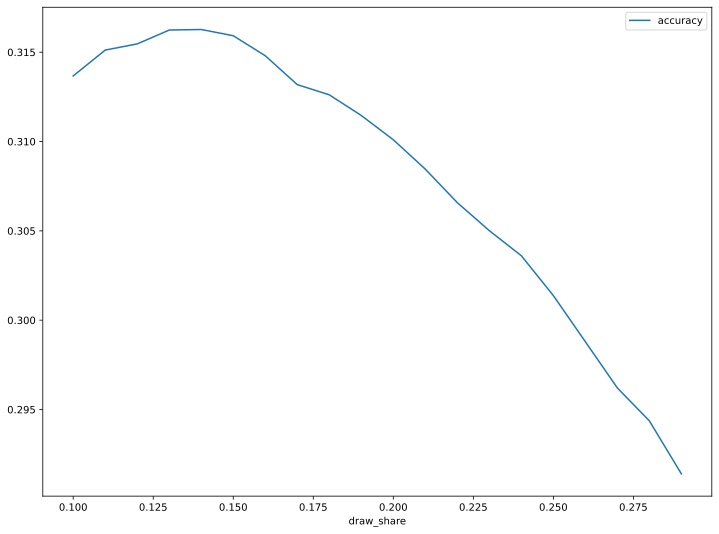

In [130]:
%%time
# пытаемся определить правильны порог ничьи
draw_lst=[]
r_lst=[]
for d in range(10, 30):
    dsh=float(d)/100
    print(dsh)
    draw_lst.append(dsh)
    test_df['predict']=test_df[['team', 'opponent']].apply(
                    lambda x: elo_predict(x[0], x[1], dsh), axis=1)
    r_lst.append(count_metric(test_df))
draw_share_df=pd.DataFrame([draw_lst, r_lst]).T
draw_share_df.columns=['draw_share', 'accuracy']

print(np.argmax(draw_share_df['accuracy']))
draw_share_df.set_index('draw_share').plot()

In [183]:
test_df['predict']=test_df[['team', 'opponent']].apply(
                    lambda x: elo_predict(x[0], x[1], 0.14), axis=1)

# test_df['predict']=test_df[['team', 'opponent']].apply(
#                     lambda x: simple_predict(x[0], x[1]), axis=1)

# test_df['predict']=test_df[['team', 'opponent']].apply(
#                     lambda x: random_predict(x[0], x[1]), axis=1)

test_df['propability']=test_df[['team', 'opponent']].apply(
                    lambda x: elo_prob(
                                    current_rating_dict.get(x[0], 2400), 
                                    current_rating_dict.get(x[1], 2400), 
                                    ), axis=1)


test_df['wins']=test_df[['team', 'opponent']].apply(lambda x:
                                current_stat_dict.get(x[0]+'-'+x[1], [0,0,0,0,0])[0],
                                                axis=1)
test_df['draws']=test_df[['team', 'opponent']].apply(lambda x:
                                current_stat_dict.get(x[0]+'-'+x[1], [0,0,0,0,0])[1],
                                                axis=1)
test_df['loses']=test_df[['team', 'opponent']].apply(lambda x:
                                current_stat_dict.get(x[0]+'-'+x[1], [0,0,0,0,0])[2],
                                                axis=1)
test_df['scored']=test_df[['team', 'opponent']].apply(lambda x:
                                current_stat_dict.get(x[0]+'-'+x[1], [0,0,0,0,0])[3],
                                                axis=1)
test_df['mised']=test_df[['team', 'opponent']].apply(lambda x:
                                current_stat_dict.get(x[0]+'-'+x[1], [0,0,0,0,0])[4],
                                                axis=1)
test_df['results_difference']=test_df['wins']-test_df['loses']
test_df['goals_difference']=test_df['scored']-test_df['mised']


test_df['propability_group']=np.floor(test_df['propability']*10)/10
test_df['days_from_start']=(test_df['date']-datetime.strptime("2018-06-01", "%Y-%m-%d")).dt.days

<ipython-input-183-611e332d9898>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predict']=test_df[['team', 'opponent']].apply(
<ipython-input-183-611e332d9898>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['propability']=test_df[['team', 'opponent']].apply(
<ipython-input-183-611e332d9898>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [192]:
test_df['predict'].value_counts()

Lose    65
Win     65
Draw    56
Name: predict, dtype: int64

In [185]:
test_df.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y,predict,propability,wins,draws,loses,scored,mised,results_difference,goals_difference,propability_group,days_from_start
7742,382862,2019-06-01,japan,national,Oita Trinita,FC Tokyo,Away,Lose,F,1,3,Asia,japan,japan,JP,JP,Oita Trinita (Japan),FC Tokyo (Japan),data/football-data/data/results/japan.csv,919,Lose,Lose,0.291642,4.0,4.0,8.0,10.0,17.0,-4.0,-7.0,0.2,365
3331,218062,2019-06-01,zimbabwe,national,Black Rhinos,Herentals,Home,Win,F,2,1,Africa,zimbabwe,zimbabwe,ZW,ZW,Black Rhinos (Zimbabwe),Herentals (Zimbabwe),data/football-data/data/results/zimbabwe.csv,116,Win,Draw,0.530144,0.0,1.0,1.0,1.0,4.0,-1.0,-3.0,0.5,365
6565,1076002,2019-06-01,georgia,national,Wit Georgia,Torpedo Kutaisi,Home,Win,F,3,0,Europe,georgia,georgia,GE,GE,Wit Georgia (Georgia),Torpedo Kutaisi (Georgia),data/football-data/data/results/georgia.csv,16,Win,Lose,0.195687,8.0,15.0,18.0,35.0,52.0,-10.0,-17.0,0.1,365


In [196]:
team_df[team_df['country']=='spain'][0:3]

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y
0,703540,1929-02-10,spain,national,Atletico Madrid,Arenas De Getxo,Away,Win,F,3,2,Europe,spain,spain,ES,ES,Atletico Madrid (Spain),Arenas De Getxo (Spain),data/football-data/data/results/spain.csv,127,Win
2,703542,1929-02-10,spain,national,Ce Europa,Real Madrid,Away,Lose,F,0,5,Europe,spain,spain,ES,ES,Ce Europa (Spain),Real Madrid (Spain),data/football-data/data/results/spain.csv,97,Lose
3,703543,1929-02-10,spain,national,Athletic Bilbao,Real Sociedad,Away,Draw,F,1,1,Europe,spain,spain,ES,ES,Athletic Bilbao (Spain),Real Sociedad (Spain),data/football-data/data/results/spain.csv,1,Draw


In [198]:
team_df[team_df['country']=='spain']['team'].value_counts().index

Index(['FC Barcelona', 'Real Madrid', 'Valencia CF', 'Athletic Bilbao',
       'Atletico Madrid', 'Espanyol Barcelona', 'Sevilla FC', 'Real Sociedad',
       'Real Zaragoza', 'Real Betis', 'Celta Vigo', 'Deportivo La Coruna',
       'Real Valladolid', 'Sporting Gijon', 'Racing Santander', 'CA Osasuna',
       'Malaga CF', 'Real Oviedo', 'Ud Las Palmas', 'RCD Mallorca',
       'Villarreal CF', 'Granada CF', 'Rayo Vallecano', 'Elche CF',
       'Hercules CF', 'Real Murcia', 'Getafe CF', 'CD Tenerife', 'Levante Ud',
       'Cd Alaves', 'Cadiz CF', 'Ce Sabadell', 'Ud Salamanca', 'CD Logrones',
       'Cd Castellon', 'Burgos CF', 'Cordoba CF', 'Albacete', 'Ud Almeria',
       'Sd Eibar', 'Recreativo Huelva', 'Pontevedra CF', 'Sd Compostela',
       'CD Numancia', 'Arenas De Getxo', 'Gimnastic', 'CD Leganes',
       'Cd Alcoyano', 'Real Jaen', 'CF Extremadura', 'Merida Ad', 'Girona FC',
       'Real Union', 'Ad Almeria', 'Ce Europa', 'Xerez Cd', 'SD Huesca',
       'Lleida Esportiu', 'Atleti

In [112]:
x_fields=['propability', 'results_difference', 'wins', 'goals_difference']

X_train=train_df[x_fields]
y_train=train_df['y'].values

X_test=test_df[x_fields]
y_test=test_df['y'].values

In [113]:
X_train.sample(3)

,propability,results_difference,wins,goals_difference
2667,0.386181,-3.0,1.0,-5.0
20998,0.496832,-3.0,2.0,-2.0
3991,0.480684,3.0,22.0,-11.0


In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, accuracy_score
clf = RandomForestClassifier(
                    n_estimators=10,
                    max_depth=4,
                    random_state=11)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [135]:
def culc_metrics(y_test, y_pred):
    import sklearn.metrics as skm
    metrics=pd.DataFrame([
                len(X_test),
                skm.accuracy_score(y_test, y_pred),
                skm.precision_score(y_test, y_pred, average='macro'),
                skm.recall_score(y_test, y_pred, average='macro'),
                skm.f1_score(y_test, y_pred, average='macro')
            ]).T
    metrics.columns=[
        'sample_size',
        'accuracy_score', 'precision', 'recall', 'f1'
    ]
    
    return metrics

In [136]:
metrics=culc_metrics(y_test, y_pred)

In [ ]:
n_default=10
depth_default=4

In [142]:
%%time
metrics_df=pd.DataFrame()
for n in range(2,20):
    print(n)
    clf = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=depth_default,
                    random_state=11)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    b=culc_metrics(y_test, y_pred)
    b['n']=n
    b['depth']=depth_default
    metrics_df=pd.concat([metrics_df, b])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 3min 8s, sys: 7.59 s, total: 3min 16s
Wall time: 3min 16s


<AxesSubplot:xlabel='depth'>

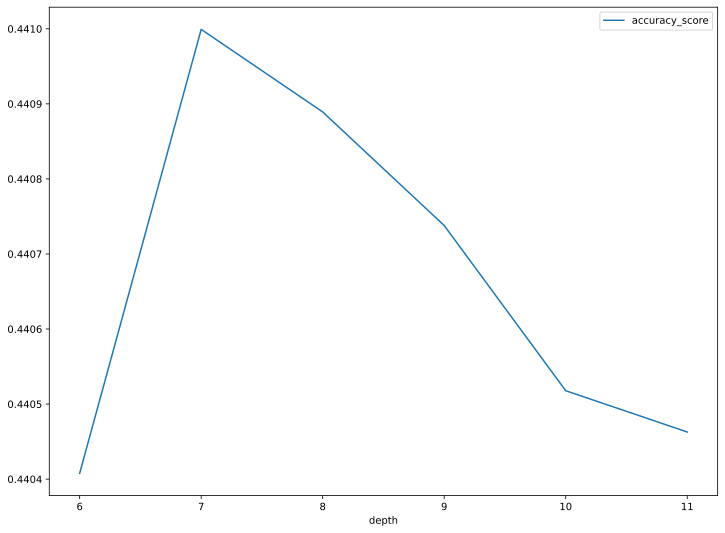

In [154]:
metrics_df.set_index('depth')[['accuracy_score']].plot()

<AxesSubplot:xlabel='depth'>

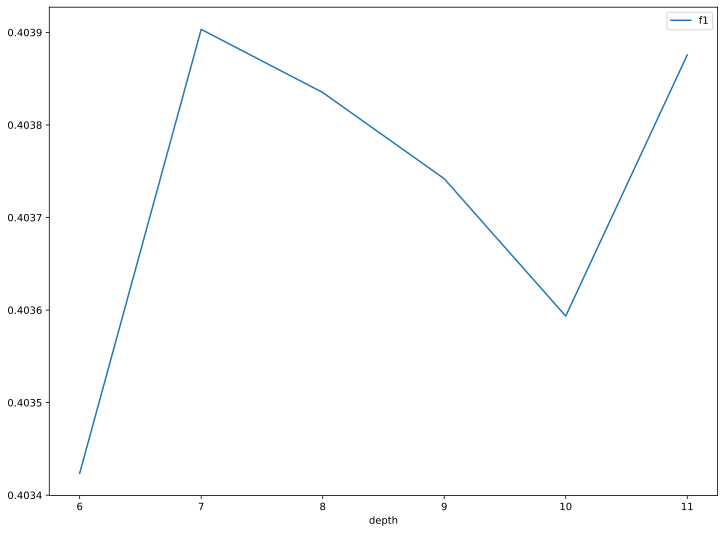

In [155]:
metrics_df.set_index('depth')[['f1']].plot()

In [156]:
metrics_df

,sample_size,accuracy_score,precision,recall,f1,n,depth
0,72694.0,0.440408,0.403260,0.411729,0.403424,10,6
0,72694.0,0.440999,0.403779,0.412259,0.403903,10,7
0,72694.0,0.440889,0.403635,0.412160,0.403835,10,8
0,72694.0,0.440738,0.403548,0.412041,0.403742,10,9
0,72694.0,0.440518,0.403404,0.411861,0.403593,10,10
0,72694.0,0.440463,0.403633,0.411959,0.403876,10,11


In [153]:
%%time
n_default=10
depth_default=4

metrics_df=pd.DataFrame()
for depth in range(6,12):
    print(n)
    clf = RandomForestClassifier(
                    n_estimators=n_default,
                    max_depth=depth,
                    random_state=11)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    b=culc_metrics(y_test, y_pred)
    b['n']=n_default
    b['depth']=depth
    metrics_df=pd.concat([metrics_df, b])

19
19
19
19
19
19
CPU times: user 1min 26s, sys: 2.35 s, total: 1min 28s
Wall time: 1min 28s


In [158]:
best_d=7
best_n=10
clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_d,
                    random_state=11)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [159]:
def get_feature_importance(clf):
    # feature importances
    importances = clf.feature_importances_

    col=X_train.columns
    fi=pd.DataFrame(col, columns=['feature'])
    fi['importance']=importances
    fi=fi.sort_values(by='importance', ascending=False)
    fi.index=range(len(fi))
    fi['position']=fi.index
    # fi['importance'] = (fi['importance']*100).map('{:.2f}%'.format) 
    return fi

In [160]:
get_feature_importance(clf)

,feature,importance,position
0,results_difference,0.283771,0
1,wins,0.244138,1
2,propability,0.237627,2
3,goals_difference,0.234464,3


In [163]:
test_df['predict']=y_pred

<ipython-input-163-a4fa5142c2db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predict']=y_pred


In [164]:
test_df.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y,predict,propability,propability_group,days_from_start,wins,draws,loses,scored,mised,results_difference,goals_difference
5070,255693,2019-03-31,china-pr,national,Tianjin Songjiang FC,Shandong Luneng,Home,Lose,F,2,4,Asia,china-pr,china-pr,CPR,CPR,Tianjin Songjiang FC (China Pr),Shandong Luneng (China Pr),data/football-data/data/results/china-pr.csv,1,Lose,Win,0.530954,0.5,303,1.0,2.0,0.0,3.0,2.0,1.0,1.0
1268,858481,2018-10-31,Copa Sud,international,Deportivo Cali,Santa Fe,Home,Lose,F,1,2,South America,colombia,colombia,CO,CO,Deportivo Cali (Colombia),Santa Fe (Colombia),data/football-data/data/results/copa-sud.csv,1055,Lose,Lose,0.398620,0.3,152,24.0,22.0,17.0,88.0,70.0,7.0,18.0
19086,114198,2019-04-13,netherlands,national,ADO Den Haag,AZ Alkmaar,Away,Win,F,3,2,Europe,netherlands,netherlands,NL,NL,ADO Den Haag (Netherlands),AZ Alkmaar (Netherlands),data/football-data/data/results/netherlands.csv,302,Win,Lose,0.274099,0.2,316,6.0,3.0,19.0,26.0,62.0,-13.0,-36.0


<AxesSubplot:>

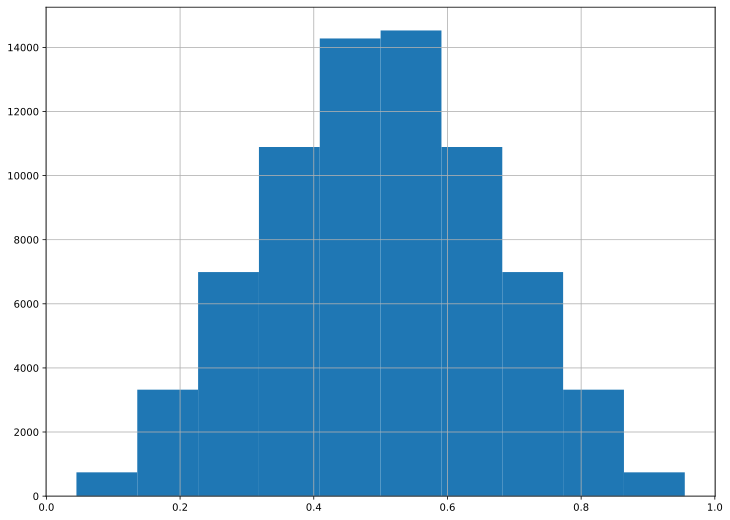

In [165]:
test_df['propability'].hist()

In [166]:
def count_metric(test_df):
    import sklearn.metrics as skm
    m=[
        skm.accuracy_score(test_df['y'], test_df['predict']),
        skm.precision_score(test_df['y'], test_df['predict'], average='macro'),
        skm.recall_score(test_df['y'], test_df['predict'], average='macro'),
        skm.f1_score(test_df['y'], test_df['predict'], average='macro')
    ]
    
    return m[0]

In [167]:
def metric_by_segmens(test_df, segment):
    segments=[]
    df_lst=[]
    for el in test_df[segment].value_counts().index:
        b=test_df[test_df[segment]==el]
        df_lst.append(b)
        segments.append(el)
    metrics=[]
    for el in df_lst:
        m=count_metric(el)
        metrics.append(m)

    result=pd.DataFrame()
    result['segment']=segments
    result['accuracy']=metrics
    
    return result.sort_values(by='accuracy', ascending=False)

In [168]:
count_metric(test_df)

0.44099925716015076

In [169]:
metric_by_segmens(test_df, 'level')

,segment,accuracy
0,national,0.448777
1,international,0.291016


In [172]:
metric_by_segmens(test_df, 'continent')

,segment,accuracy
6,world,0.500000
5,Oceania,0.474306
0,Europe,0.473280
2,Asia,0.456177
3,North America,0.431078
4,South America,0.425855
1,Africa,0.394088


In [173]:
metric_by_segmens(test_df, 'competition')[0:10]

/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

,segment,accuracy
149,kyrgyzstan,0.742857
190,british-virgin-islands,0.727273
112,estonia,0.686747
184,cook-islands,0.666667
171,belize,0.653333
199,liechtenstein,0.642857
137,faroe-islands,0.641129
160,aruba,0.617978
163,macao,0.602410
106,ireland-republic,0.592179


In [174]:
metric_by_segmens(test_df[test_df['competition']=='england'], 
                  'team')[0:10]

/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

,segment,accuracy
11,Manchester City,0.842105
2,Liverpool FC,0.736842
15,Huddersfield Town,0.657895
13,Tottenham Hotspur,0.657895
7,Arsenal FC,0.605263
10,Fulham FC,0.552632
3,Manchester United,0.552632
9,Chelsea FC,0.552632
16,West Ham United,0.526316
12,Afc Bournemouth,0.526316


In [134]:
metric_by_segmens(test_df[test_df['competition']=='spain'], 
                  'team')[0:10]

/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: Undefi

,segment,accuracy
12,FC Barcelona,0.657895
13,Atletico Madrid,0.578947
16,Real Madrid,0.552632
3,Sevilla FC,0.526316
5,Girona FC,0.500000
11,Espanyol Barcelona,0.473684
0,Cd Alaves,0.447368
17,Athletic Bilbao,0.447368
10,Real Betis,0.447368
6,Rayo Vallecano,0.421053


In [135]:
cl=metric_by_segmens(test_df, 'propability_group').sort_values(by='segment')

/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification

<AxesSubplot:xlabel='segment'>

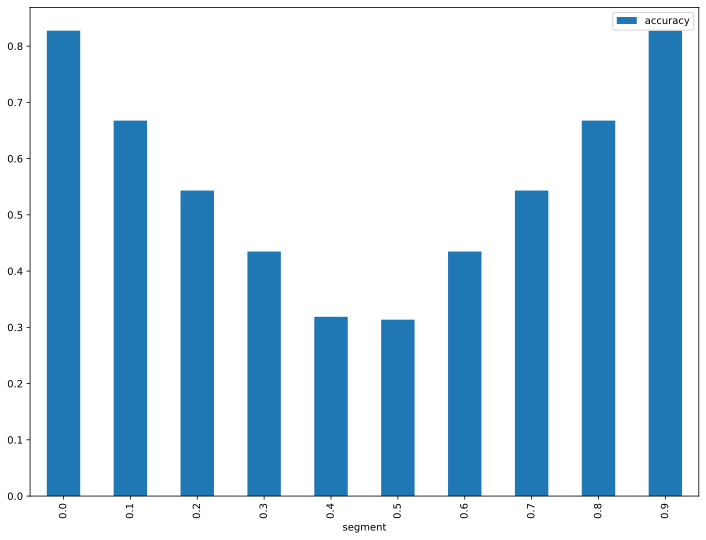

In [136]:
cl.set_index('segment').plot(kind='bar')

In [175]:
days=metric_by_segmens(test_df, 'days_from_start').sort_values(by='segment')

/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roman/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

<AxesSubplot:xlabel='segment'>

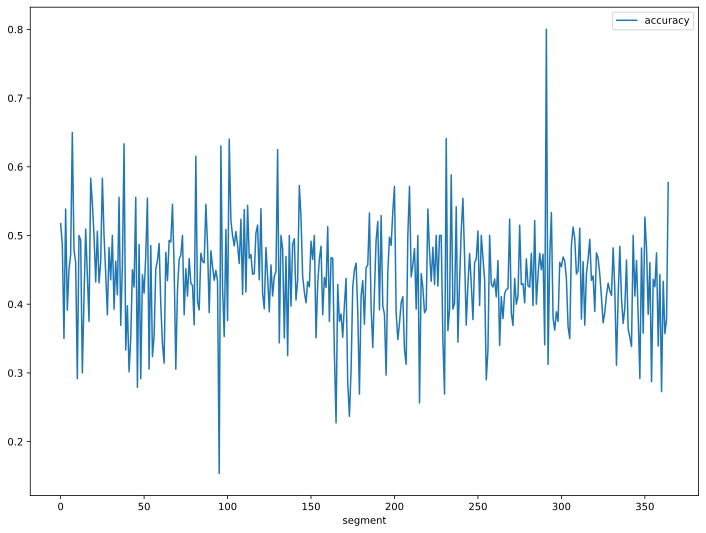

In [176]:
days.set_index('segment').plot()

In [139]:
team_df.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y
5272,1003608,2000-08-24,UEFA EL,international,Vorskla Poltava,FK Rabotnicki,Away,Win,F,2,0,Europe,ukraine,macedonia-fyr,UA,MAC,Vorskla Poltava (Ukraine),FK Rabotnicki (Macedonia Fyr),data/football-data/data/results/uefa-el.csv,83,Win
1920,406185,1996-11-02,morocco,national,Maghrib Association Tetouan,FAR de Rabat,Home,Draw,F,1,1,Africa,morocco,morocco,MA,MA,Maghrib Association Tetouan (Morocco),FAR de Rabat (Morocco),data/football-data/data/results/morocco.csv,929,Draw
5905,552207,2018-03-03,czech-republic,national,MFK Karvina,Slovan Liberec,Away,Draw,F,2,2,Europe,czech-republic,czech-republic,CZ,CZ,MFK Karvina (Czech Republic),Slovan Liberec (Czech Republic),data/football-data/data/results/czech-republic.csv,363,Draw


In [106]:
team_df, current_rating_dict=count_elo_rating(team_df)
lstr=team_df[
    (team_df['competition']=='england')&
    (team_df['date']>='2015-06-01')&
    (team_df['date']<'2017-06-01')&
    (team_df['team'].isin(['Leicester City', 'Liverpool FC', 'Newcastle United', 'Arsenal FC'])==True)
]

In [107]:
len(lstr)

266

In [108]:
lstr.sample(3)

,match_id,date,competition,level,team,opponent,venue,result,result_kind,team_score,opponent_score,continent,country,opponent_country,country_code,opponent_country_code,full_team_name,opponent_full_team_name,file,game_number,y,rating,opponent_rating,rating_changing
47494,698730,2016-04-24,england,national,Leicester City,Swansea City,Home,Win,F,4,0,Europe,england,wales,ENG,WAL,Leicester City (England),Swansea City (Wales),data/football-data/data/results/england.csv,1590,Win,2662.556315,2593.480928,4.133731
47787,699023,2017-02-27,england,national,Leicester City,Liverpool FC,Home,Win,F,3,1,Europe,england,england,ENG,ENG,Leicester City (England),Liverpool FC (England),data/football-data/data/results/england.csv,56,Win,2592.599065,2703.528313,6.717019
47309,698545,2015-12-14,england,national,Leicester City,Chelsea FC,Home,Win,F,2,1,Europe,england,england,ENG,ENG,Leicester City (England),Chelsea FC (England),data/football-data/data/results/england.csv,74,Win,2592.977330,2770.298143,7.516206


<AxesSubplot:xlabel='date', ylabel='rating'>

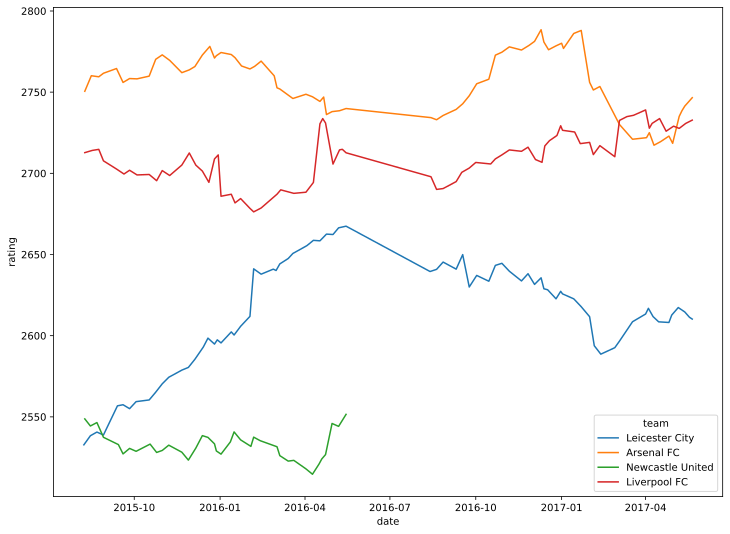

In [109]:
sns.lineplot(data=lstr, x='date', y='rating', hue='team')

In [110]:
lstr['propability']=lstr[['team', 'opponent']].apply(
                    lambda x: elo_prob(
                                    current_rating_dict.get(x[0], 2400), 
                                    current_rating_dict.get(x[1], 2400), 
                                    ), axis=1)


lstr[lstr['team']=='Leicester City'][['propability']].describe()

<ipython-input-110-7ce97809706a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstr['propability']=lstr[['team', 'opponent']].apply(


,propability
count,76.000000
mean,0.480474
std,0.159855
min,0.165160
25%,0.301090
50%,0.534882
75%,0.599361
max,0.737132


In [111]:
lstr[lstr['team']=='Arsenal FC'][['propability']].describe()

,propability
count,76.000000
mean,0.672570
std,0.154145
min,0.314705
25%,0.649766
50%,0.727479
75%,0.776419
max,0.866832


In [112]:
# # таблица текущих рейтингов
# rating_df=pd.DataFrame.from_dict(current_rating_dict, orient='index', columns=['current_ratings'])
# rating_df=rating_df.sort_values(by='current_ratings', ascending=False)

In [113]:
# countries_lst=team_df['country'].value_counts().index
# exmpl=team_df[
#     (team_df['country']==countries_lst[0])&
#     (team_df['date']>='2002-01-01')
# ]
# top=exmpl.groupby('team').median()[[
#     'rating']].sort_values(by='rating', ascending=False)[0:4].reset_index()['team'].values
# sns.lineplot(data=exmpl[
#     exmpl['team'].isin(top)
#                         ], x='date', y='rating', hue='team')